In [43]:
import time

import pandas as pd 
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss 
from imblearn.pipeline import make_pipeline
from imblearn.metrics import geometric_mean_score

import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit, StratifiedKFold, KFold
from sklearn import neighbors, svm, tree, linear_model, ensemble, neural_network, metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score, precision_recall_curve, average_precision_score, cohen_kappa_score,\
classification_report, log_loss, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

#########################################################################

%matplotlib inline
pd.set_option("max_columns",90, "max_rows", 90)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys 
sys.path.insert(0, 'C:\\Users\\qzhang\\PycharmProjects\\Mei')
from utility import model_fit

from sklearn.preprocessing import StandardScaler

def data_prep(raw_df):
    """"""
    df = raw_df.copy()
    
    JUD_ST = ('CT', 'DE', 'FL', 'IL', 'IN', 'KS', 'KY', 'LA', 'ME', 'MA',
              'NE', 'NJ', 'NM', 'NY', 'ND', 'OH', 'OK', 'PA', 'SC', 'SD',
              'VT', 'WI')
    CATE_VAR = ['orig_chn', 'loan_purp', 'prop_type', 'occ_stat', 'judicial_st', 'fhb_flag']

    # drop columns
    df.drop(['loan_id', 'status_prev', 'msa'], axis=1, inplace=True)

    # drop all the observation with missing value
    df.dropna(how='any', inplace=True)

    # create a new feature based on prop_state
    df.loc[:, 'judicial_st'] = df['prop_state'].apply(lambda x: 'Y' if x in JUD_ST else 'N')
    df.drop(['prop_state'], axis=1, inplace=True)

    # convert status to 0 or 1
    df.loc[:, 'status'] = df['status'].apply(lambda x: int(x == 'D60-D90'))

    X = df.drop(['status'], axis=1).copy()
    num_feats = list(set(X.columns) - set(CATE_VAR))
    X = pd.get_dummies(X, columns=CATE_VAR)
    y = df['status'].copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # mean is computed only over the training data and then subtracted equally from all splits(train/val/test)
    scaler = StandardScaler()
    X_train.loc[:, num_feats] = scaler.fit(X_train[num_feats]).transform(X_train[num_feats])
    X_test.loc[:, num_feats] -= scaler.mean_
    X_test.loc[:, num_feats] /= scaler.scale_
    return X_train, X_test, y_train, y_test

# read data
raw_df = pd.read_csv('..\Data\Gse_panel_current_sample_raw.csv')


In [45]:
# split sample set
X_train, X_vt, y_train, y_vt = data_prep(raw_df)
X_val, X_test, y_val, y_test = train_test_split(X_vt, y_vt, test_size=0.25, random_state=5)

C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [146]:
num_pos = np.sum(y_train == 1)
num_neg = y_train.shape[0] - np.sum(y_train == 1)
p1 = np.sum(y_train == 1) / y_train.shape[0]

loss_at_chance = -(num_pos*np.log(p1) + num_neg*np.log(1-p1)) / y_train.shape[0]
loss_at_chance

In [163]:
X_train.shape

(799982, 46)

In [100]:
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Nadam
from keras.layers import Dropout
from keras import backend as K

In [153]:
model = Sequential()
model.add(Dense(80, activation='relu', name="hidden_1", input_dim=X_train.shape[1]))  # , kernel_regularizer=regularizers.l2(0.001)
model.add(Dense(20, activation='relu', name="hidden_2"))
model.add(Dense(1, activation='sigmoid', name="op"))
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())
b_size=128
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=b_size, shuffle=True, verbose=2)  # , class_weight={0:1, 1:10}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 80)                3760      
_________________________________________________________________
hidden_2 (Dense)             (None, 20)                1620      
_________________________________________________________________
op (Dense)                   (None, 1)                 21        
Total params: 5,401
Trainable params: 5,401
Non-trainable params: 0
_________________________________________________________________
None
Train on 799982 samples, validate on 149997 samples
Epoch 1/10
 - 18s - loss: 0.0244 - acc: 0.9975 - val_loss: 0.0147 - val_acc: 0.9977
Epoch 2/10
 - 18s - loss: 0.0135 - acc: 0.9978 - val_loss: 0.0145 - val_acc: 0.9977
Epoch 3/10
 - 17s - loss: 0.0133 - acc: 0.9978 - val_loss: 0.0144 - val_acc: 0.9977
Epoch 4/10
 - 16s - loss: 0.0132 - acc: 0.9978 - val_loss: 0.0145 - val_acc: 0.9977
Epoch 5/10


C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


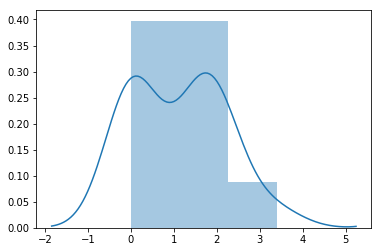

In [177]:
from keras.models import Model
layer_name = 'hidden_2'
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_val)

sns.distplot(intermediate_output[0])

In [137]:
# history = model.fit(X_train, y_train, validation_split=0.2, initial_epoch=30, epochs=40, batch_size=b_size, shuffle=True, verbose=2)

149997/149997 [==============================] - 2s 13us/step
['loss', 'acc'] [0.014330145172140846, 0.9976732867990693]


C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'Classifier': 'Neural Networks', 'PR_AUC': 0.017847494156883345, 'ROC_AUC': 0.8460883430901995, 'Expeted num of D60-D90': 316.48624, 'Actual num of D60-D90': 349, 'F score': 0.03868471953578337, 'G mean': 0.16918345860521775}


C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


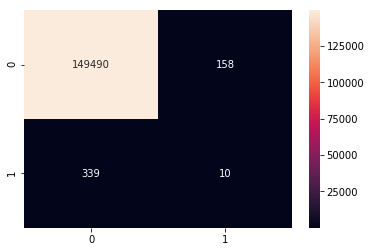

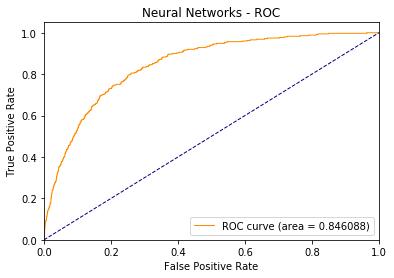

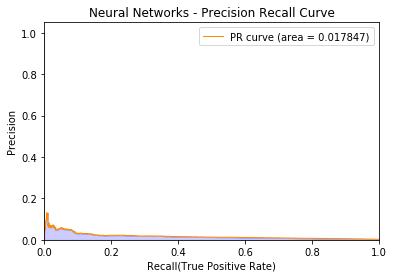

In [138]:
# evaluat - return loss and any other metrics requested, batch size should as large as possible when evaluating or predicting
scores = model.evaluate(X_val, y_val, batch_size=b_size)   
print(model.metrics_names, scores)

# predict 
prob_pos = model.predict(X_val, batch_size=b_size, verbose=0) 
vfunc = np.vectorize(lambda x: 1 if x > 0.05 else 0)
y_pred = vfunc(prob_pos)
# sns.heatmap(confusion_matrix(y_test, model.predict_classes(X_test, batch_size=400, verbose=0)), annot=True, fmt="d")

# calculate related metrics
precision, recall, _ = precision_recall_curve(y_val, prob_pos)
fpr, tpr, _ = roc_curve(y_val, prob_pos)
roc_auc = auc(fpr, tpr)
pr_auc = average_precision_score(y_val, prob_pos)
exp_pos = np.sum(prob_pos)
f_score = f1_score(y_val, y_pred)
g_mean = geometric_mean_score(y_val, y_pred)

op = {'Classifier': 'Neural Networks',
      'PR_AUC': pr_auc,
      'ROC_AUC': roc_auc,
      'Expeted num of D60-D90': exp_pos,
      'Actual num of D60-D90': np.sum(y_val),
      'F score': f_score,
      'G mean': g_mean}
print(op)

# PLOT - confusion matrix
ax_cm = sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d")

# PLOT - ROC_AUC
fig_ra = plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.6f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Neural Networks - ROC')
plt.legend(loc="lower right")
fig_ra.show()

# PLOT - PR_AUC
fig_pr = plt.figure()
plt.plot(recall, precision, color='darkorange', lw=1,
         label='PR curve (area = %0.6f)' % pr_auc)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall(True Positive Rate)')
plt.ylabel('Precision')
plt.title(f'Neural Networks - Precision Recall Curve')
plt.legend(loc="upper right")


fig_pr.show()

# {'Classifier': 'Neural Networks', 'PR_AUC': 0.018236309507601578, 'ROC_AUC': 0.8498468844475554, 'Expeted num of D60-D90': 5715.9766, 'Actual num of D60-D90': 664, 'F score': 0.023541653118293555, 'G mean': 0.700739626845605}
# {'Classifier': 'Neural Networks', 'PR_AUC': 0.017018686309638778, 'ROC_AUC': 0.8505524813650084, 'Expeted num of D60-D90': 614.0507, 'Actual num of D60-D90': 664, 'F score': 0.045569620253164564, 'G mean': 0.20148335637766554}

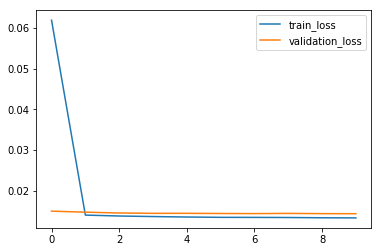

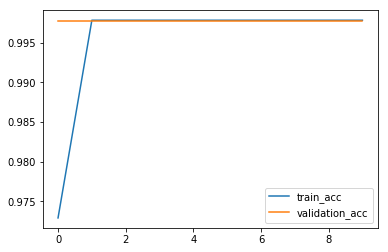

In [139]:
h = history.history

plt.figure()
plt.plot(h['loss'], label='train_loss')
plt.plot(h['val_loss'], label='validation_loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(h['acc'], label='train_acc')
plt.plot(h['val_acc'], label='validation_acc')
plt.legend()
plt.show()

C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'Classifier': 'Neural Networks Training Set', 'PR_AUC': 0.022531493102587067, 'ROC_AUC': 0.8719654387355565, 'Expeted num of D60-D90': 1694.5854, 'Actual num of D60-D90': 1743, 'F score': 0.04363905325443787, 'G mean': 0.18387885886008243}


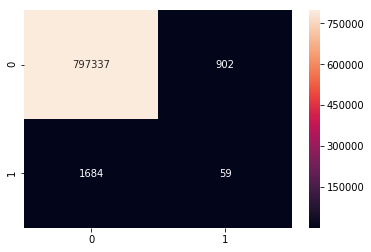

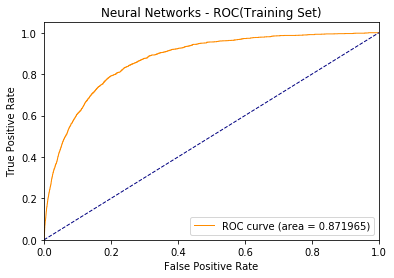

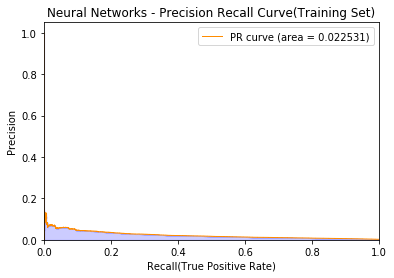

In [140]:
# predict 
prob_pos = model.predict(X_train, batch_size=b_size, verbose=0) 
vfunc = np.vectorize(lambda x: 1 if x > 0.05 else 0)
y_pred = vfunc(prob_pos)

# calculate related metrics
precision, recall, _ = precision_recall_curve(y_train, prob_pos)
fpr, tpr, _ = roc_curve(y_train, prob_pos)
roc_auc = auc(fpr, tpr)
pr_auc = average_precision_score(y_train, prob_pos)
exp_pos = np.sum(prob_pos)
f_score = f1_score(y_train, y_pred)
g_mean = geometric_mean_score(y_train, y_pred)

op = {'Classifier': 'Neural Networks Training Set',
      'PR_AUC': pr_auc,
      'ROC_AUC': roc_auc,
      'Expeted num of D60-D90': exp_pos,
      'Actual num of D60-D90': np.sum(y_train),
      'F score': f_score,
      'G mean': g_mean}
print(op)

# PLOT - confusion matrix
ax_cm = sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt="d")

# PLOT - ROC_AUC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.6f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Neural Networks - ROC(Training Set)')
plt.legend(loc="lower right")
plt.show()

# PLOT - PR_AUC
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=1,
         label='PR curve (area = %0.6f)' % pr_auc)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall(True Positive Rate)')
plt.ylabel('Precision')
plt.title(f'Neural Networks - Precision Recall Curve(Training Set)')
plt.legend(loc="upper right")
plt.show()

In [141]:
model.get_config()

[{'class_name': 'Dense',
  'config': {'name': 'dense_79',
   'trainable': True,
   'batch_input_shape': (None, 46),
   'dtype': 'float32',
   'units': 80,
   'activation': 'relu',
   'use_bias': True,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'scale': 1.0,
     'mode': 'fan_avg',
     'distribution': 'uniform',
     'seed': None}},
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'kernel_regularizer': None,
   'bias_regularizer': None,
   'activity_regularizer': None,
   'kernel_constraint': None,
   'bias_constraint': None}},
 {'class_name': 'Dropout',
  'config': {'name': 'dropout_5',
   'trainable': True,
   'rate': 0.2,
   'noise_shape': None,
   'seed': None}},
 {'class_name': 'Dense',
  'config': {'name': 'dense_80',
   'trainable': True,
   'units': 20,
   'activation': 'relu',
   'use_bias': True,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'scale': 1.0,
     'mode': 'fan_avg',
     'distribution': 'u